# Lösung des Problems für Standard-Geometrie
## Includes

In [1]:
import sys, os
# Add the ImportExport directory to sys.path
import_export_dir = os.path.join(os.path.join(os.getcwd(), '..'), 'ImportExport')
if import_export_dir not in sys.path:
    sys.path.append(import_export_dir)
from global_parameters import *
from EddyCurrentProblem import *
from ThermalConductivityProblem import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import *
from netgen.geom2d import SplineGeometry
import numpy as np

## Importieren des Meshs und der Stromdichte

In [2]:
mesh = Mesh("../ImportExport/myStdMesh.vol")
Vstore = L2(mesh, order=4)
Jimp = GridFunction(Vstore)
Jimp.Load("../ImportExport/JimpStdGeo.gf")

## Lösung des Wirbelstromproblems (Vektorpotential $A_\phi$)

In [3]:
# Create an instance of the problem
ecp = EddyCurrentProblem(mesh, Jimp, omega, sigma, nu)

# Solve the problem
gfu = ecp.solve()

# Draw the solution
if gfu:
    ecp.draw_solution()

Assembling BilinearForm 'a'...
Assembling LinearForm 'f'...
Solving system for A_phi...
System solved.
Drawing |A_phi| (Magnitude of A_phi)...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

## Berechnung und Visualisierung B-Feld
Aus dem Vektorpotential $A_\phi$ können nun mit den Gleichungen {eq}`eq:Brotsym` die Komponenten des B-Feldes berechnet werden.

In [4]:
ecp.calculate_b_field()
ecp.draw_b_field_components()

Calculating B-field components...


B-field components calculated.
Drawing B_z (complex)...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

Drawing B_r (complex)...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

Drawing |B| (Magnitude of B-field)...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

## B-Feld zeitabhängig
In Anlehnung an Gleichung {eq}`eq:Azeit` kann der Realteil des B-Feldes zeitabhängig dargestellt werden.

In [5]:
ecp.draw_b_vector_field(time_val=0, vectors={"grid_size":30})
ecp.draw_b_vector_field(time_val=10e-3, vectors={"grid_size":30})

Drawing B-vector field (real part) at t = 0 ms ...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Drawing B-vector field (real part) at t = 10.0 ms ...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

```{note}
Folgende Dinge können am B-Feld beobachtet werden
- Wie es für eine zylinderförmige Spule zu erwarten ist, ist das B-Feld in der Mitte am stärksten.
- Die Feldlinien sind im Innern der Spule näherungsweise parallel zur Rotationsachse.
- Das Feld ändert die Richtung periodisch (Pfeilrichtung daher bei $\frac{T}{2} = 10\, \mathrm{ms}$ umgekehrt als bei $0\, \mathrm{ms}$)
- Am Rand ist zu beobachten, was in {numref}`bfeld_rand` festgehalten ist.
```

In [6]:
#ecp.showAnimation(store_ani=True)

![GIF animation of B-field](../ImportExport/animation.gif)

## Induktive Wärmequelle
Nun wird die induktive Wärmequelle gemäss {numref}`lst:induktiv_waerme` berechnet.

In [7]:
Qe = ecp.calculate_thermal_source()

if Qe:
    Draw(Qe, mesh)

Calculating thermal source Qe...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

## Stationäre Wärmeverteilung

### Lösen des Systems für gemischte Randbedingungen
Zuerst wird die stationäre Wärmeverteilung für die gemischten Randbedingungen aus {ref}`ref:NGsolveWaermeKap` gelöst.
Der exemplarische Fall ist physikalisch nicht besonders sinnvoll, aber mathematisch interessant.

In [8]:
tp = ThermalConductivityProblem(mesh, Qe, lam, dirichlet_boundaries='outer_right')
tp.set_dirichlet_values('outer_right', 10)
tp.add_neumann_boundary_condition('outer_top', -200, lamAir)
tp.add_robin_boundary_condition('outer_left', 100, lamAir)

Setting up H1 space with Dirichlet boundaries: 'outer_right'
Setting Dirichlet value on 'outer_right'.
Adding Neumann BC on 'outer_top' with given dT/dn
Adding Robin BC on 'outer_left' with given alpha


Assembling BilinearForm a_T...
Assembling LinearForm f_T...
Solving thermal system...
Thermal system solved.
Drawing Temperature...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Plotting boundary conditions...


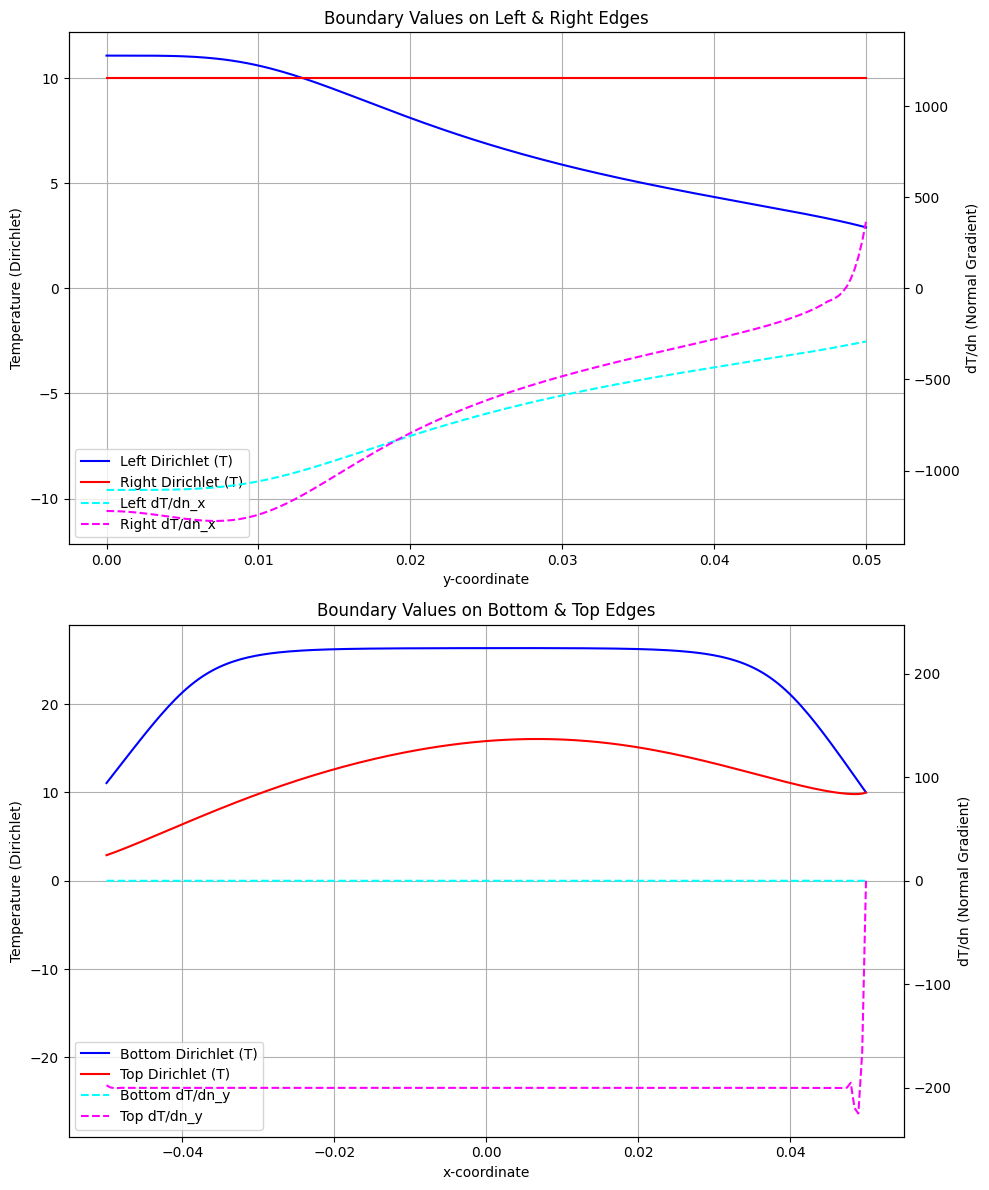

In [9]:
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()
    tp.plot_boundary_conditions()

```{note}
Die unterschiedlichen Randbedingungen können nun an den Plots nachvollzogen werden:
- Rechter Rand: Es gilt konstant $T=10$ (Dirichlet-Randbedingung erfüllt)
- Linker Rand: Es gilt $\nabla T \cdot \mathbf{n} = -\underbrace{100}_{\alpha}\, T$ (Robin-Randbedingung erfüllt)
- Oberer Rand: Es gilt $\nabla T \cdot \mathbf{n} = -200$ (Neumann-Randbedingung erfüllt, ausser an Ecken, weil dort Konflikt mit anderen Randwerten)
- Unterer Rand (Rotationsachse): Es gilt $\nabla T \cdot \mathbf{n} = 0$ (homogene Neumann-Randbedingung erfüllt), kein Temperaturfluss
```

### Stationäre Wärmeverteilung homogener Dirichlet-Rand
Nun werden für die äusseren Ränder homogene Dirichlet-Randwerte $(T=0)$ angenommen.

In [10]:
tp.update_dirichlet_boundaries('outer_left|outer_top|outer_right')
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()

Setting up H1 space with Dirichlet boundaries: 'outer_left|outer_top|outer_right'
Dirichlet boundaries updated to: 'outer_left|outer_top|outer_right'
Assembling BilinearForm a_T...
Assembling LinearForm f_T...
Solving thermal system...
Thermal system solved.
Drawing Temperature...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

### Lösen des Systems für Robin-Randbedingung
Wie in Abschnitt {ref}`ref:RobinRand` beschrieben, lässt sich eine teilweise Isolation mit Robin-Randbedingungen modellieren. Je tiefer der Parameter $\alpha$, desto besser die Isolation.
#### Robin-Randbedingung mit $\alpha=1$

In [11]:
tp.update_dirichlet_boundaries('')
alpha = 1
tp.add_robin_boundary_condition('outer_left|outer_top|outer_right', alpha, lamAir)
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()

Setting up H1 space with Dirichlet boundaries: ''
Dirichlet boundaries updated to: ''
Adding Robin BC on 'outer_left|outer_top|outer_right' with given alpha
Assembling BilinearForm a_T...
Assembling LinearForm f_T...
Solving thermal system...
Thermal system solved.
Drawing Temperature...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

```{note}
- Gute Isolation mit $\alpha=1$ (hohe Temperatur)
```

#### Robin-Randbedingung mit $\alpha=10$

In [12]:
alpha = 10
tp.add_robin_boundary_condition('outer_left|outer_top|outer_right', alpha, lamAir)
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()

Adding Robin BC on 'outer_left|outer_top|outer_right' with given alpha
Assembling BilinearForm a_T...
Assembling LinearForm f_T...
Solving thermal system...
Thermal system solved.
Drawing Temperature...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

```{note}
- Mittelmässige Isolation mit $\alpha=10$
```

#### Robin-Randbedingung mit $\alpha=1000$

In [13]:
alpha = 1000
tp.add_robin_boundary_condition('outer_left|outer_top|outer_right', alpha, lamAir)
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()

Adding Robin BC on 'outer_left|outer_top|outer_right' with given alpha
Assembling BilinearForm a_T...
Assembling LinearForm f_T...
Solving thermal system...
Thermal system solved.
Drawing Temperature...


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

```{note}
- Schlechte Isolation mit $\alpha=1000$ (fast gleiche Temperaturverteilung wie bei Dirichlet-Randbedingung)
```